In [1]:
# -- Import
from winnow.calibration.calibration_features import (
    PrositFeatures,
    MassErrorFeature,
    RetentionTimeFeature,
)
from winnow.calibration.calibrator import ProbabilityCalibrator
from winnow.datasets.calibration_dataset import RESIDUE_MASSES, CalibrationDataset

from winnow.fdr.database_grounded import DatabaseGroundedFDRControl
from winnow.fdr.bayes import EmpiricalBayesFDRControl

import logging

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import seaborn.objects as so
from seaborn import axes_style

theme_dict = {**axes_style("whitegrid"), "grid.linestyle": ":"}

In [2]:
# -- Set up logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

**Note**: `winnow` will not work with modifications or beam-related features at the moment. Extending support for modifications will allow computation on beam features again. I have removed these for now because I am concerned it will filter out too many spectra to also remove any rows with modifications on any of the beams.

In [3]:
# -- Load data
SPECIES = "tpl_antibodies"  # [antibody, gluc, hela_qc, herceptin, immuno_subset, s_brodae, snake_venoms, tpl_antibodies, wound_fluids]

logger.info("Loading dataset.")
dataset = CalibrationDataset.from_predictions_csv(
    spectrum_path=f"../validation_dataset_mount/{SPECIES}_labelled.ipc",
    predictions_path=f"../mount_folder/validation_datasets/{SPECIES}_labelled_beam_preds.csv",
)

logger.info("Filtering dataset.")
# TODO: confirm only low confidence identifications
filtered_dataset = (
    dataset.filter_entries(
        metadata_predicate=lambda row: not isinstance(row["prediction"], list),
    )
    # .filter_entries(
    #     metadata_predicate=lambda row: "N(+.98)" in row["prediction"],
    # )
    # .filter_entries(
    #     metadata_predicate=lambda row: "Q(+.98)" in row["prediction"],
    # )
    .filter_entries(metadata_predicate=lambda row: not row["prediction"])
)

TEST_FRACTION = 0.2
RANDOM_STATE = 42
train, test = train_test_split(
    filtered_dataset, test_size=TEST_FRACTION, random_state=RANDOM_STATE
)

train_metadata, train_predictions = zip(*train)
train_dataset = CalibrationDataset(
    metadata=pd.DataFrame(train_metadata).reset_index(drop=True),
    predictions=list(train_predictions),
)

test_metadata, test_predictions = zip(*test)
test_dataset = CalibrationDataset(
    metadata=pd.DataFrame(test_metadata).reset_index(drop=True),
    predictions=list(test_predictions),
)

Loading dataset.


Filtering out predictions containing modifications and invalid precursor charges.


Filtering dataset.


In [4]:
print(len(train_dataset))
print(len(test_dataset))

13209
3303


In [5]:
# -- Set up calibrator
logger.info("Initialising calibrator.")
SEED = 42
calibrator = ProbabilityCalibrator(SEED)

logger.info("Adding features to calibrator.")
MZ_TOLERANCE = 0.02
HIDDEN_DIM = 10
TRAIN_FRACTION = 0.1
calibrator.add_feature(MassErrorFeature(residue_masses=RESIDUE_MASSES))
calibrator.add_feature(PrositFeatures(mz_tolerance=MZ_TOLERANCE))
calibrator.add_feature(
    RetentionTimeFeature(hidden_dim=HIDDEN_DIM, train_fraction=TRAIN_FRACTION)
)
# calibrator.add_feature(ChimericFeatures(mz_tolerance=MZ_TOLERANCE))  # TODO: to be fixed for new IN version.
# calibrator.add_feature(BeamFeatures())  # TODO: to be fixed for new IN version.

Initialising calibrator.
Adding features to calibrator.


In [6]:
# -- Calibrate
logger.info("Calibrating scores.")
calibrator.fit(train_dataset)
calibrator.predict(test_dataset)

Calibrating scores.


Prosit_2020_intensity_HCD::   0%|          | 0/14 [00:00<?, ?it/s]

Prosit_2019_irt::   0%|          | 0/2 [00:00<?, ?it/s]

/home/j-daniel/Repos/winnow/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Prosit_2019_irt::   0%|          | 0/14 [00:00<?, ?it/s]

Prosit_2020_intensity_HCD::   0%|          | 0/4 [00:00<?, ?it/s]

Prosit_2019_irt::   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
train_dataset.to_csv(f"../calibrated_datasets/{SPECIES}_train_labelled.csv")
test_dataset.to_csv(f"../calibrated_datasets/{SPECIES}_test_labelled.csv")

test_dataset.metadata

,fileno,spectrum_index,global_index,precursor_mz,precursor_charge,sample,experiment_name,peptide,prediction,confidence,...,correct,Mass Error,prosit_mz,prosit_intensity,ion_matches,ion_match_intensity,iRT,predicted iRT,iRT error,calibrated_confidence
0,9,12252,13075,470.23099,2,sampledata3_9,tpl_antibodies_labelled,"[S, W, S, F, G, E, V, K]","[S, W, S, F, G, E, V, K]",9.981677e-01,...,True,-0.002393,"[147.11280822753906, 246.18121337890625, 274.1...","[0.03372465819120407, 0.07989650964736938, 0.3...",0.818182,0.230759,73.616989,46.148276,27.468713,0.990754
1,9,9623,22744,544.92303,3,sampledata3_9,tpl_antibodies_labelled,"[T, Q, E, D, S, R, E, W, P, E, T, V, R]","[N, P, E, D, M, R, D, E, D, T, I, A, A, R]",1.773659e-04,...,False,0.026299,"[115.05020141601562, 159.10023498535156, 175.1...","[0.0004426866944413632, 0.003027266124263406, ...",0.058824,0.070610,19.672626,38.066979,18.394353,0.035817
2,7,8845,13561,487.58804,3,sampledata3_7,tpl_antibodies_labelled,"[E, A, E, P, E, I, Y, N, A, I, R, R]","[E, A, E, P, E, I, Y, N, A, I, R, R]",1.206863e-01,...,True,0.000327,"[101.04712677001953, 175.11895751953125, 201.0...","[0.00038943890831433237, 0.013361537829041481,...",0.733333,0.229369,49.581013,37.336827,12.244186,0.551672
3,2,4789,20831,394.71606,2,sampledata3_2,tpl_antibodies_labelled,"[I, G, A, S, I, D, G, R]","[I, G, G, I, S, E, G, R]",1.084465e-02,...,False,-0.001278,"[171.11280822753906, 171.11280822753906, 175.1...","[0.20049285888671875, 0.001326112076640129, 0....",0.500000,0.220679,4.713692,22.377194,17.663502,0.201524
4,5,13528,16116,582.78931,2,sampledata3_5,tpl_antibodies_labelled,"[T, D, P, D, F, V, I, M, A, R]","[T, D, P, D, F, V, T, I, E, K]",1.383092e-03,...,False,-0.006974,"[147.11280822753906, 215.08444213867188, 217.0...","[0.01150595210492611, 0.0009858127450570464, 0...",0.352941,0.071921,62.149700,51.557952,10.591748,0.125881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3298,13,11767,3656,939.43427,3,sampledata3_13,tpl_antibodies_labelled,"[I, T, S, S, D, D, D, G, R, T, W, G, Q, G, T, ...","[I, T, S, S, S, D, D, G, R, E, W, G, Q, G, T, ...",4.821679e-02,...,False,-0.008706,"[57.54930877685547, 74.06004333496094, 114.091...","[0.0019894056022167206, 0.0010798039147630334,...",0.432836,0.334324,56.980579,45.916313,11.064267,0.176294
3299,7,3136,3255,499.25333,3,sampledata3_7,tpl_antibodies_labelled,"[R, S, S, E, V, Y, G, Q, T, N, I, G, G, K]","[R, S, S, E, V, Y, G, Q, T, N, I, G, G, K]",9.892378e-01,...,True,-0.004543,"[87.72342681884766, 111.06233215332031, 147.11...","[0.0007061910000629723, 0.0002800788206513971,...",0.500000,0.453713,6.674362,18.254025,11.579663,0.958730
3300,12,13265,3902,467.72977,4,sampledata3_12,tpl_antibodies_labelled,"[W, E, V, S, E, D, G, K, T, Y, T, F, H, I, R]","[W, E, V, S, E, D, G, K, T, Y, T, F, H, I, R]",2.888319e-01,...,True,-0.000117,"[175.11895751953125, 213.1345977783203, 251.61...","[0.07908288389444351, 0.09921294450759888, 0.0...",0.368421,0.066296,63.917847,46.577707,17.340140,0.369510
3301,9,14904,14517,455.80701,2,sampledata3_9,tpl_antibodies_labelled,"[I, T, V, V, P, I, I, R]","[I, T, V, V, P, I, I, R]",3.543477e-01,...,True,-0.001701,"[175.11895751953125, 207.1415557861328, 215.13...","[0.018764425069093704, 0.0008734612492844462, ...",0.538462,0.497791,95.872620,53.971565,41.901055,0.527287


In [8]:
# -- Evaluate and plot
def compute_roc_curve(
    input_dataset: CalibrationDataset,
    confidence_column: str,
    label_column: str,
    name: str,
) -> pd.DataFrame:
    original = input_dataset.metadata[[confidence_column, label_column]].copy(deep=True)
    original = original.sort_values(by=confidence_column, ascending=False)
    cum_correct = np.cumsum(original[label_column])
    precision = cum_correct / np.arange(1, len(original) + 1)
    recall = cum_correct / len(original)
    metrics = pd.DataFrame({"precision": precision, "recall": recall}).reset_index(
        drop=True
    )
    metrics["name"] = name
    return metrics

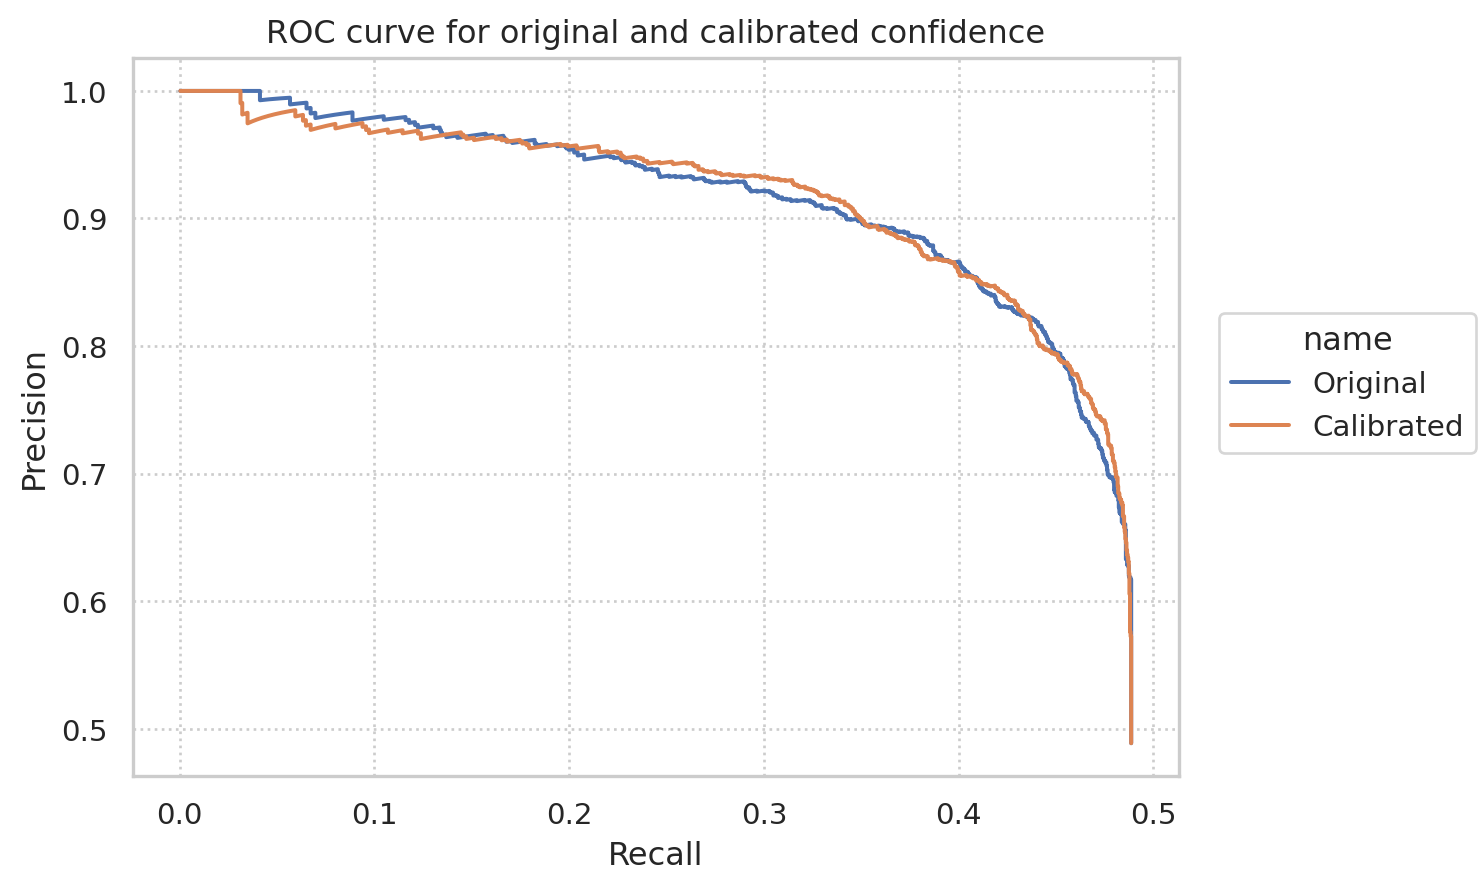

In [9]:
original = compute_roc_curve(
    input_dataset=test_dataset,
    confidence_column="confidence",
    label_column="correct",
    name="Original",
)
calibrated = compute_roc_curve(
    input_dataset=test_dataset,
    confidence_column="calibrated_confidence",
    label_column="correct",
    name="Calibrated",
)
metrics = pd.concat([original, calibrated], axis=0).reset_index(drop=True)
metrics["fdr"] = 1 - metrics["precision"]

plot = so.Plot(metrics, x="recall", y="precision", color="name")
plot = plot.add(so.Line(), group="name")
plot = plot.theme(theme_dict)
plot = plot.label(
    y="Precision", x="Recall", title="ROC curve for original and calibrated confidence"
)
plot

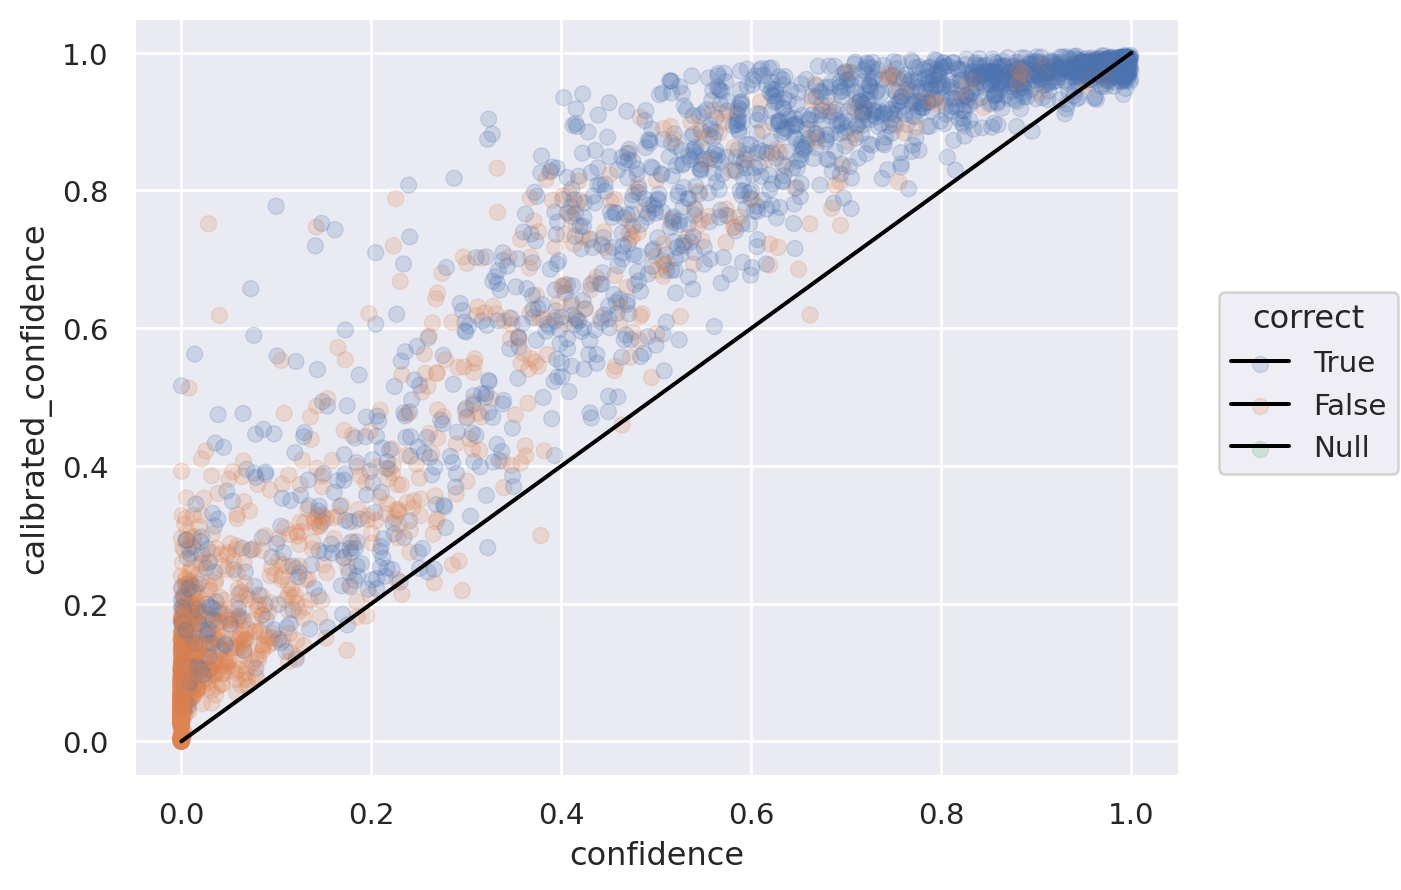

In [10]:
# TODO: quantify confidence shift
data = test_dataset.metadata[["confidence", "calibrated_confidence", "correct"]].copy(
    deep=True
)
data["correct"] = pd.Categorical(data["correct"])

so.Plot(data, x="confidence", y="calibrated_confidence", color="correct").add(
    so.Dot(alpha=0.2)
).add(
    so.Line(color="black", linestyle="-"),
    data=pd.DataFrame(
        {
            "confidence": [0.0, 1.0],
            "calibrated_confidence": [0.0, 1.0],
            "correct": ["Null", "Null"],
        }
    ),
)

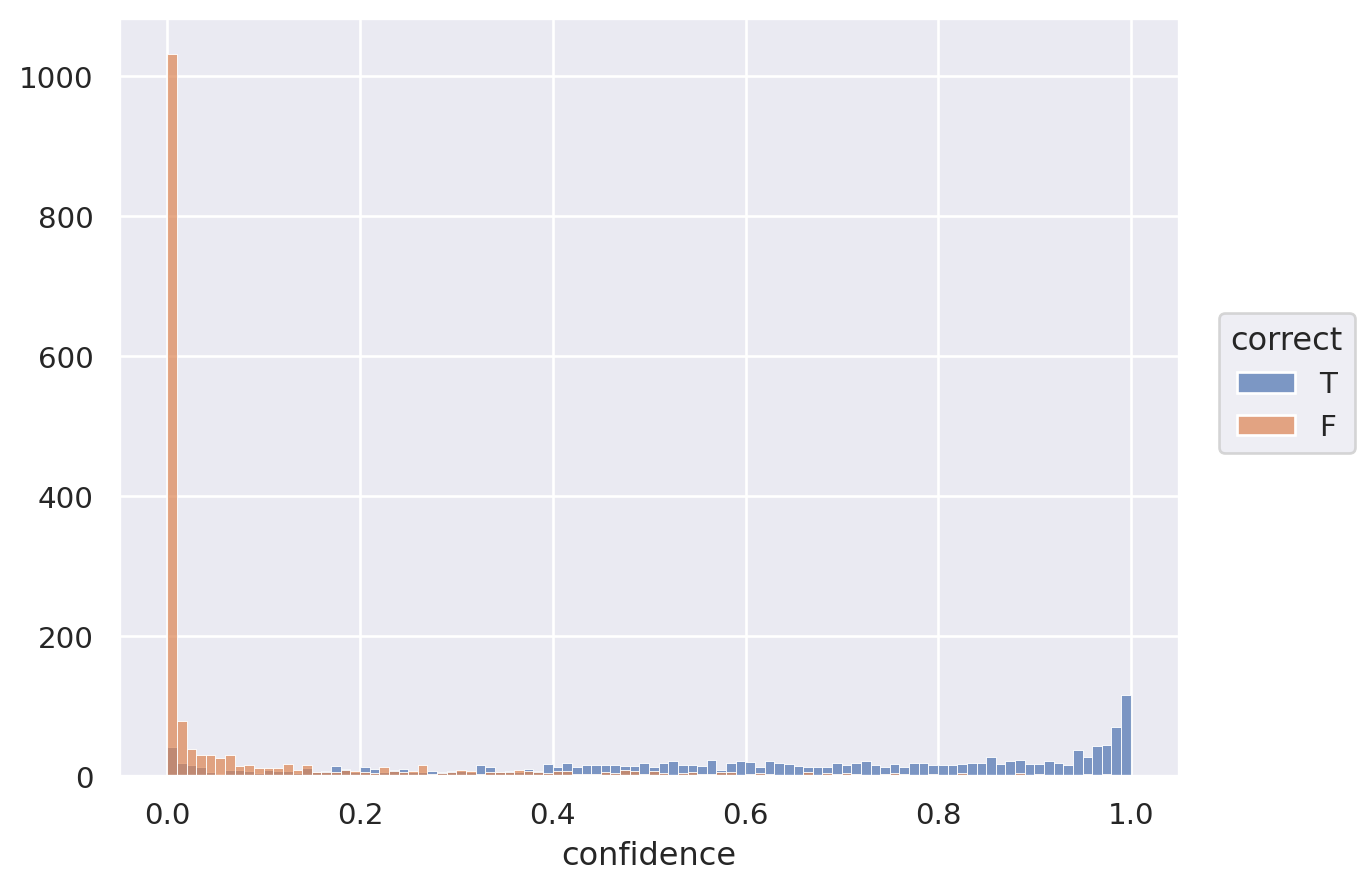

In [11]:
plot_df = test_dataset.metadata[["confidence", "correct"]].copy(deep=True)
plot_df["correct"] = plot_df["correct"].apply(lambda x: "T" if x else "F")
so.Plot(plot_df, "confidence").add(so.Bars(), so.Hist(bins=100), color="correct")

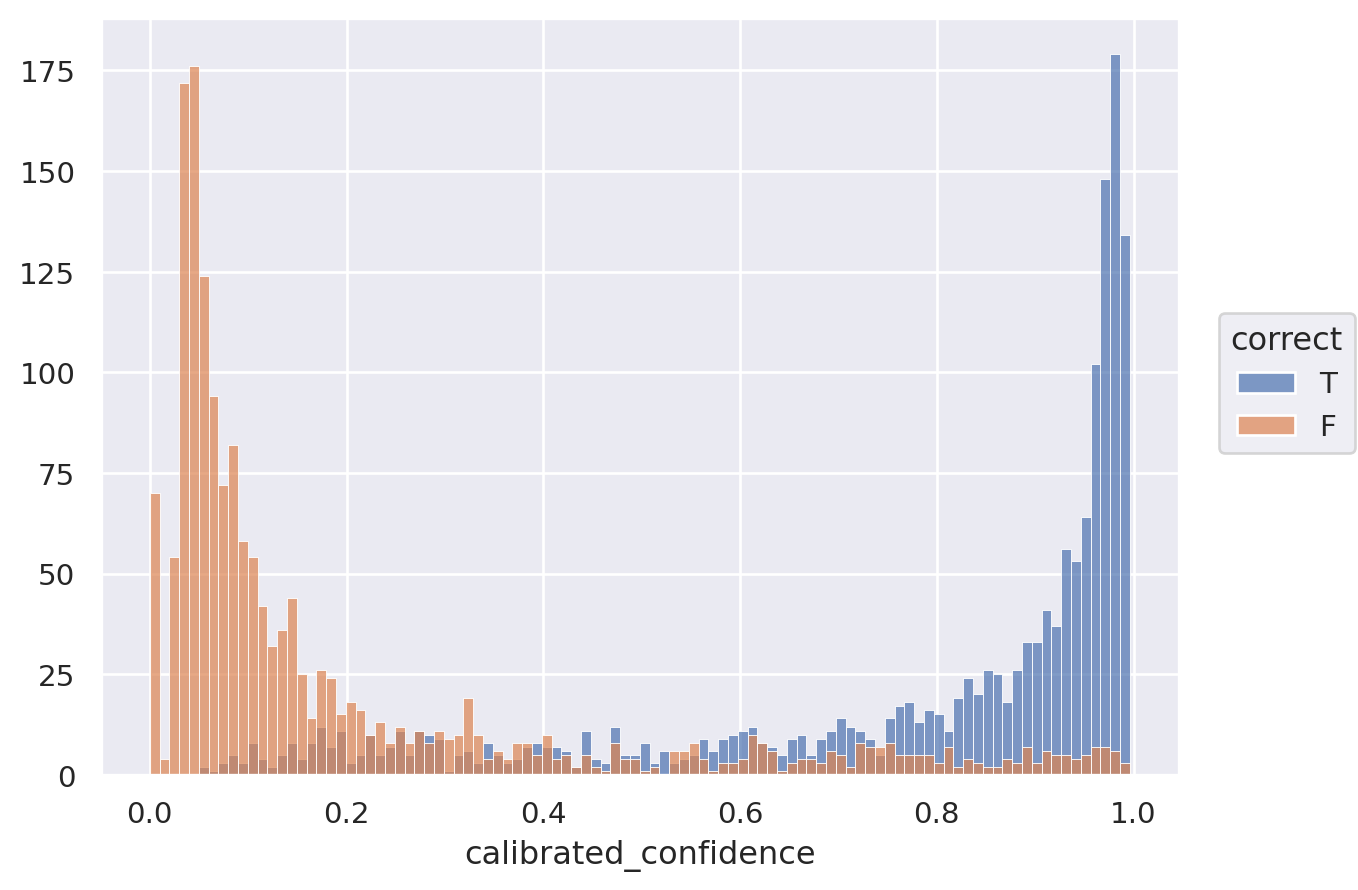

In [12]:
plot_df = test_dataset.metadata[["calibrated_confidence", "correct"]].copy(deep=True)
plot_df["correct"] = plot_df["correct"].apply(lambda x: "T" if x else "F")
so.Plot(plot_df, "calibrated_confidence").add(
    so.Bars(), so.Hist(bins=100), color="correct"
)

In [13]:
database_grounded_fdr_control = DatabaseGroundedFDRControl(
    confidence_feature="confidence"
)
database_grounded_fdr_control.fit(
    dataset=test_dataset.metadata, residue_masses=RESIDUE_MASSES
)
database_grounded_fdr_control.get_confidence_cutoff(threshold=0.05)

0.7518110769308272

In [14]:
mixture_fdr_control = EmpiricalBayesFDRControl()
mixture_fdr_control.fit(dataset=test_dataset.metadata["confidence"])
mixture_fdr_control.get_confidence_cutoff(threshold=0.05)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
100%|██████████| 5000/5000 [00:01<00:00, 3943.80it/s, init loss: -4638.2427, avg. loss [4751-5000]: -7133.0819]


0.7761784493904997

In [15]:
mixture_fdr_control = EmpiricalBayesFDRControl()
mixture_fdr_control.fit(dataset=test_dataset.metadata["calibrated_confidence"])
mixture_fdr_control.get_confidence_cutoff(threshold=0.05)

100%|██████████| 5000/5000 [00:01<00:00, 4101.47it/s, init loss: -598.5570, avg. loss [4751-5000]: -630.4097]


0.9999999701958586